# Load the Model

This script will load the previously trained ML model and try to use it to predict the output frequency for different data conditons.

First we will be using the model trained on a stationary heart beat to detect a model that has a moving heart beat. The data loaded below has a heart beat which is linearly chirping at a rate of 1 Hz in 10 seconds. 

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import Input as Input
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D,Conv1D
from keras.models import Sequential
from keras.layers import Dropout
from keras import layers
from keras.layers import BatchNormalization
import h5py
import scipy.signal as sig
from scipy import signal
print(keras.__version__)

2.4.3


In [2]:
def getSpec(x,win,winSize,fs,fLimit,y_dat,out,inner):
    #Generate Spectrogram
    f, t, Sxx = signal.spectrogram(x,window=win,nperseg=winSize ,fs = fs,noverlap=winSize - 15,nfft= 10000) #Find spectrogram with high fft count
    spec = Sxx[0:fLimit,:] #We only need FFT from 0 to 6 ish Hz which is about the first 100 samples at fs=500
    f = f[0:fLimit]
    idx=np.int0(t*fs)
    if inner != -1:
        y=y_dat[idx,out,inner]
    else:
        y = y_dat[out,idx]
    return spec,f,y

# Load data

The cell below loads the .mat file which contains the data. If this does not work make sure the .mat was saved as -v7.3, which is in the h5py data format. If it is not, resave it or change this code. 

In [10]:
f = h5py.File('ML_HRV_full_fs500_long_1.mat','r') 
#f = h5py.File('ML_HRV_honly_fs500_1.mat','r') 
#f = h5py.File('ML_phaseFull_2dROC_txOffset.mat','r') 
#f = h5py.File('ML_phaseFull_2dROC_fcOffset.mat','r') 
#f = h5py.File('ML_phaseFull_2dROC_fcOffset_10mw.mat','r') 
#f = h5py.File('ML_phaseFull_2dROC_fcOffset_10mw_fixbwratio.mat','r') 
arrays = {}

for k, v in f.items():
    arrays[k] = np.array(v)

    

# Extract data into usable form
The data is in a dict by default, for ease of use lets put it into several different variables. X_dat should be a matrix of the data which is 100k by 2k where there are 100k data samples each are 2k long. 

In [11]:
print(arrays.keys())
datOut= arrays['datOut']

q= arrays['datOut']
numOfDat = datOut.shape[0]


if 'fhActual' in arrays.keys(): 
    heartLabels = arrays['fhActual']
elif 'FHA' in arrays.keys():
    heartLabels = arrays['FHA']
else:
    causeError

print(heartLabels.shape)
heartLabels = heartLabels[:,0:]

y_dat = heartLabels

## respLabels = arrays['frActual']
## respLabels = respLabels.transpose()
## respLabels = respLabels[:,0:numOfDat]


#print(datOut.shape) # 20 thousand different trials each is 16k samples long. +


#datLabels = np.empty((2,numOfDat))
#datLabels[0,:] = respLabels
#datLabels[1,:] = heartLabels

#datLabels= datLabels.transpose()
tNum = datOut.shape[0]

## x_dat = datOut[:,0:]

x_dat = datOut

#y_dat = datLabels[:,:] 



# convert the data to the right type
x_dat = x_dat.astype('float32')


print('x_dat shape:', x_dat.shape)
print(x_dat.shape[0], 'samples')
print('y_dat shape:', y_dat.shape)


lenDat = x_dat.shape[1]
numDat = x_dat.shape[0]

dict_keys(['datOut', 'fhActual', 'frActual', 't'])
(10, 50001)
x_dat shape: (10, 50001)
10 samples
y_dat shape: (10, 50001)


# Load ML model

Load the previously trained ML model

Current model uses 1900  data samples for 1 classificaiton (freq estimation)

In [12]:
    model = keras.models.load_model('Model_fs500_specModel_RespInc/')
    #model = keras.models.load_model('Model_fs500_honly_500/')
lenModel = 100
fs =500

testRunNum = 5
print(x_dat.shape[1:])
lenDat = len(x_dat[testRunNum,:])

print(lenDat)

(50001,)
50001


In [13]:
winSize = 2048  #This is the window size (found to work best for fs = 500)
fLimit = 100
win = signal.get_window('hamming',winSize) #Hamming window
hrAmp = 0.5*pow(10,-3)
hrPow = (hrAmp**2)/2



numNoise = 200
dbVec = np.linspace(-26,5,numNoise)

noiseAmpVec = hrPow * pow(10,(-dbVec/10))



rocVec = np.zeros((len(noiseAmpVec),1)) #results vector

print(np.sqrt(noiseAmpVec[-1]))

print(np.sqrt(noiseAmpVec[0]))
print(rocVec.shape)



0.00019881768219176267
0.007054317565802319
(200, 1)


In [14]:
print(x_dat[q,:].shape)

IndexError: arrays used as indices must be of integer (or boolean) type

In [15]:
# 1D ROC code
q=1 #which of the 10 test cases to run a noise comp for
for out in range(0,numNoise):
        print(out)
        noise = np.random.normal(0,np.sqrt(noiseAmpVec[out]),lenDat)


        x = x_dat[q,:] + noise
        y_d = y_dat[q,:]
        winSize = 2048 
        win = signal.get_window('hamming',winSize)
        ####### generate Spectrogram #############

        spec,f,y = getSpec(x,win,winSize,fs,fLimit,y_dat,q,-1)
    
        ####### Do Prediction ####################
        if spec.shape[0] == lenModel:
            spec = np.transpose(spec)
    
        freqEst = model.predict(spec)
        
        y = np.reshape(y, (-1, 1))
        rocVec[out] = np.mean(np.power(y-freqEst,2))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


(200, 1)


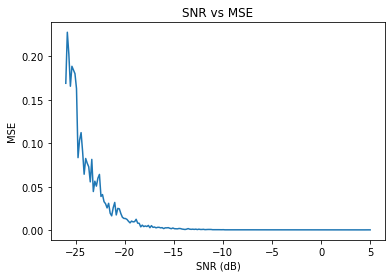

In [16]:

print(rocVec.shape)

plt.plot(dbVec,rocVec[:])

plt.ylabel('MSE')

plt.xlabel('SNR (dB)')
plt.title('SNR vs MSE')
plt.show()


In [ ]:
# 2D ROC code
rocVec = np.zeros(x_dat.shape[1:])
cc=0
for out in range(0,41):
    for inner in range(0,40):
        cc+=1
        print(cc)
        #print(k)
        #noise = np.random.normal(0,np.sqrt(noiseAmpVec[k]),lenDat)


        x = x_dat[:,out,inner] #+ noise
        y_d = y_dat[:,out,inner]
        winSize = 500 
        win = signal.get_window('hamming',winSize)
        ####### generate Spectrogram #############

        spec,f,y = getSpec(x,win,winSize,fs,fLimit,y_dat,out,inner)
    
        ####### Do Prediction ####################
        if spec.shape[0] == lenModel:
            spec = np.transpose(spec)
    
        freqEst = model.predict(spec)
        
        y = np.reshape(y, (-1, 1))
        rocVec[out,inner] = np.mean(np.power(y-freqEst,2))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:

#plt.pcolormesh(t,f,20*np.log10(Sxx), shading='gouraud') #Plot it to confirm (dont do this when actually finding it (duh))


#plt.plot(dbVec,rocVec)
plt.imshow(10*np.log10(np.transpose(rocVec)))
plt.ylabel('Power (mW)')

plt.xlabel('Offset (m)')
plt.title('MSE for carrier Freq vs Target Offset')
plt.show()

In [16]:
#rocVec

np.savetxt("fcOffset_fixxedbw_10mw.csv", rocVec, delimiter=",")

# Old Method

from IPython.display import clear_output


countVec = range(0,lenDat-lenModel,10)
#countVec = np.arange(0,lenDat-lenModel,500)

cvSize = len(countVec)

freqMat = np.zeros((1,2,cvSize +1))
cc=0
print(len(countVec))
for k in countVec:
    freqMat[0,:,cc] = model.predict(x_dat[1:2,k:k+lenModel])
    if cc %100 ==0:
        print('%.2f Percent Done '%((cc/cvSize)*100))
    cc+=1
    #print('%.2f Percent Done '%((cc/cvSize)*100))

freqEst = freqMat[0,1,:]
y=y_dat[1,countVec]
filtLen = 2
hn  = (1/filtLen)*np.ones((filtLen,))
freqEstFilt = np.convolve(freqEst,hn,'valid')
freqEstFilt

#freqEstFilt = freqEst[freqEst > np.mean(freqEst)]
#freqEstFilt = sig.decimate(freqEstFilt,14)

print(y.shape)

In [ ]:
if spec.shape[0] == lenModel:
    spec = np.transpose(spec)
    


freqEst = model.predict(spec)

In [ ]:

#np.savetxt("foo.csv", freqEstFilt, delimiter=",")
#lenEst = len(freqEstFilt)
#ts = 1/10000
#tsy = 1/10000
lenEst = len(freqEst)
t = np.linspace(0,40,lenEst)

#freqEst = freqEst - .03
#realFreq = np.linspace(y_dat[0,1],y_dat[0,1]+1,cvSize+1)

plt.plot(t,(freqEst))
plt.plot(t,y)
plt.ylabel('Frequency')
plt.xlabel('time (s)')
plt.legend(['Predicted Freqeuncy','Actual Frequency'])
plt.title('Heart Rate Frequency Estimate Comparison')
plt.show()

mseFreq = np.mean(np.power(y-freqEst,2))
print('MSE of freq Est: ',mseFreq)

In [ ]:
tpMean = np.mean(freqEstFilt)
freqEstFilt = freqEstFilt - tpMean
freqEstFilt = -abs(freqEstFilt) + tpMean


ts = 1/10000
t = np.linspace(0,40,lenEst)

print(t.shape)
#realFreq = np.linspace(y_dat[0,1],y_dat[0,1]+1,cvSize+1)

print(round(lenDat/lenEst))
y_dat_dec = sig.decimate(y_dat,round(lenDat/lenEst))


print(y_dat_dec.shape)

plt.plot(t,(freqEstFilt))
plt.plot(t,y_dat_dec[0:lenEst])
plt.ylabel('Frequency')
plt.xlabel('time (s)')
plt.legend(['Predicted Freqeuncy','Actual Frequency'])
plt.title('Heart Rate Frequency Estimate Comparison')
plt.show()

In [ ]:

t = np.linspace(0,1,lenModel)
k = countVec[3]
print(t.shape)
q=x_dat[0:1,0:lenModel]
q=q.reshape(lenModel,)
print(q.shape)
plt.plot(q)
plt.show()